# Forecasting

This page is largely used as a sandbox for creating functions and tools to achieve a streamlined method of pulling data from Fred API, performing feature engineering, and ultimately building out predictions to be able to forecast and prove effective forecasts accuracy.

Below I import some packages that I will be using to build these functions out.

In [1]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
import requests
import pandas as pd
import numpy as np
import plotly.express as px
from sklearn.preprocessing import StandardScaler
import polars as pl

## Forecasting Information Job Openings

In order to structure my progress more effectively, I feel that it can be helpful to work towards a goal. I want to be able to create a reliable 6-month forecast of the job market, initially as it pertains to Information-related jobs, but also eventually to easily query whatever industry that is available.

I am primarily using data from two sources initially - FredAPI for macroeconomic data and Yahoo Finance for stock data. I believe stock data relating to the industry being searched on will be a strong indicator - if investors have promise in a company it would make sense for hiring to increase as hiring employees is a tangent belief in the longevity of a company (it would also be interesting to factor in contracted employment).

Now I will import the functions that I have already made (and hopefully already effectively documented). Currently I have the following classes:
- **FredAPI**: pertains to all functions related to gathering Fred data.
- **YahooFinanceAPI**: pertains to all functions related to stock data gathering.

Here, I import the two:

In [2]:
from main import FredAPI, YahooFinanceAPI

Below is setting each class up -- the FredAPI class requires the input of an API key.

In [3]:
# API Key stored in .gitignore file from env folder
# Adjust variable as needed
api_key = open('env/.gitignore').read().split('\n')[2]
fred_api = FredAPI(api_key=api_key)
yahoo_finance_api = YahooFinanceAPI()

Example calling the `full_dataframe()` function from the FredAPI

In [15]:
df = fred_api.full_dataframe(['JTSJOL'])

Example calling the `daily_stock_dataframe()` function from the YahooFinanceAPI.

In [16]:
df = yahoo_finance_api.monthly_stock_dataframe("XLK")

Here are the variables I am starting off with, but I can easily change this to get different outputs. One of the first things I want to mess with is how can I capitalize on data that is represented at different frequencies? For instance, if I want to construct a forecast that looks at the next 6 months, (i.e., looking at month intervals), how can I utilize the data shown in daily, quarterly, and yearly frequencies?

In [13]:
list_variables = [
'JTU5100JOL', # Information-related Job Openings
'JTSJOL', # Total Job Openings
'UNRATE', # Unemployment Rate
'T10YIE', # 10-Year Breakeven Inflation Rate
# 'GNPCA',
]

In [35]:
econ_df = fred_api.monthly_df(list_variables).sort(by="date")

In [50]:
stocks_df = yahoo_finance_api.monthly_stock_dataframe("XLK")

In [52]:
stocks_df[["date", "last_close"]]

date,last_close
date,f64
1998-12-01,32.625
1999-01-01,37.8125
1999-02-01,34.0625
1999-03-01,36.59375
1999-04-01,36.8125
1999-05-01,36.9375
1999-06-01,40.484375
1999-07-01,40.015625
1999-08-01,41.421875


In [58]:
"fdas".title()

'Fdas'

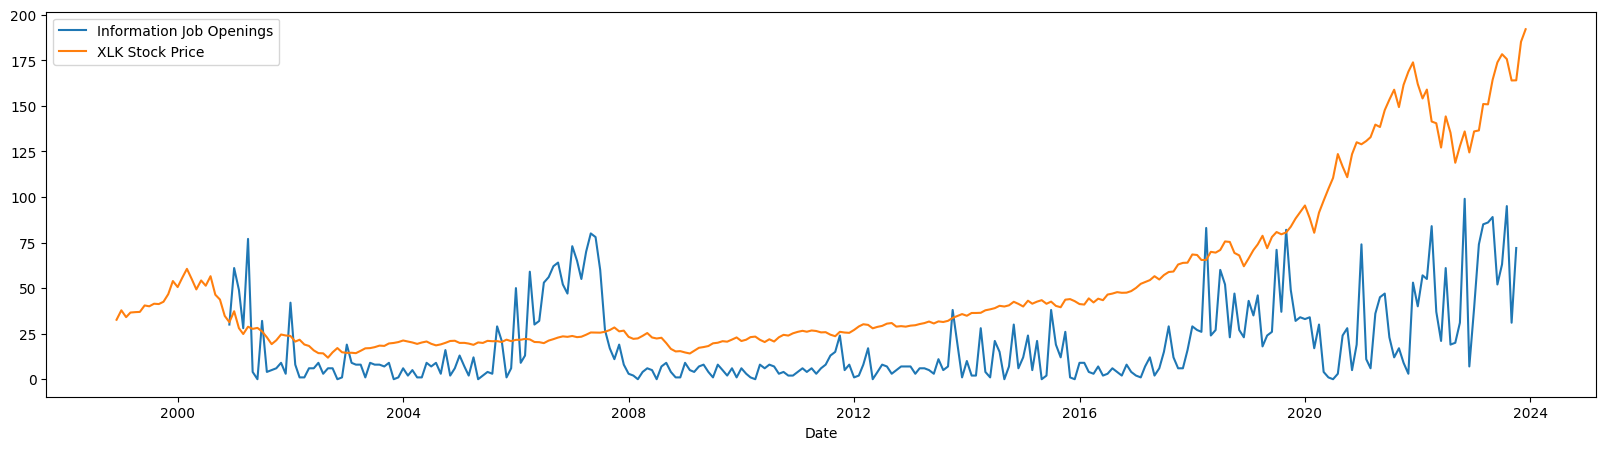

In [67]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,5))
plt.plot(econ_df["date"], econ_df["Job Openings: Information (Monthly)"], label="Information Job Openings")
plt.plot(stocks_df["date"], stocks_df["last_close"], label="XLK Stock Price")
plt.xlabel("Date")
plt.legend()

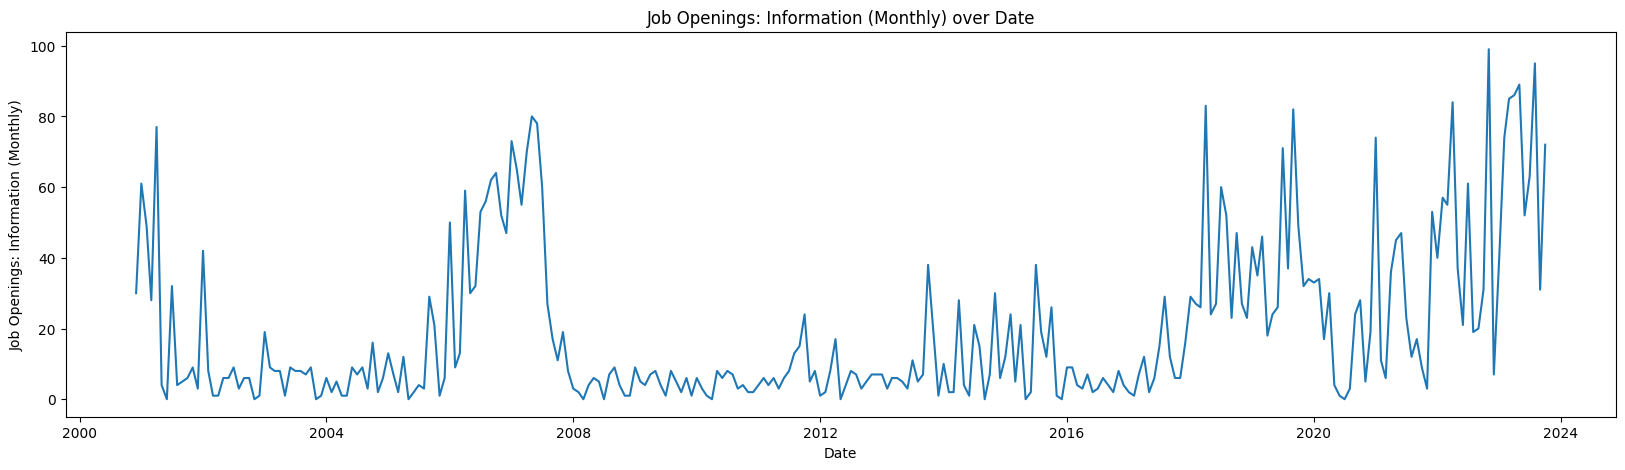

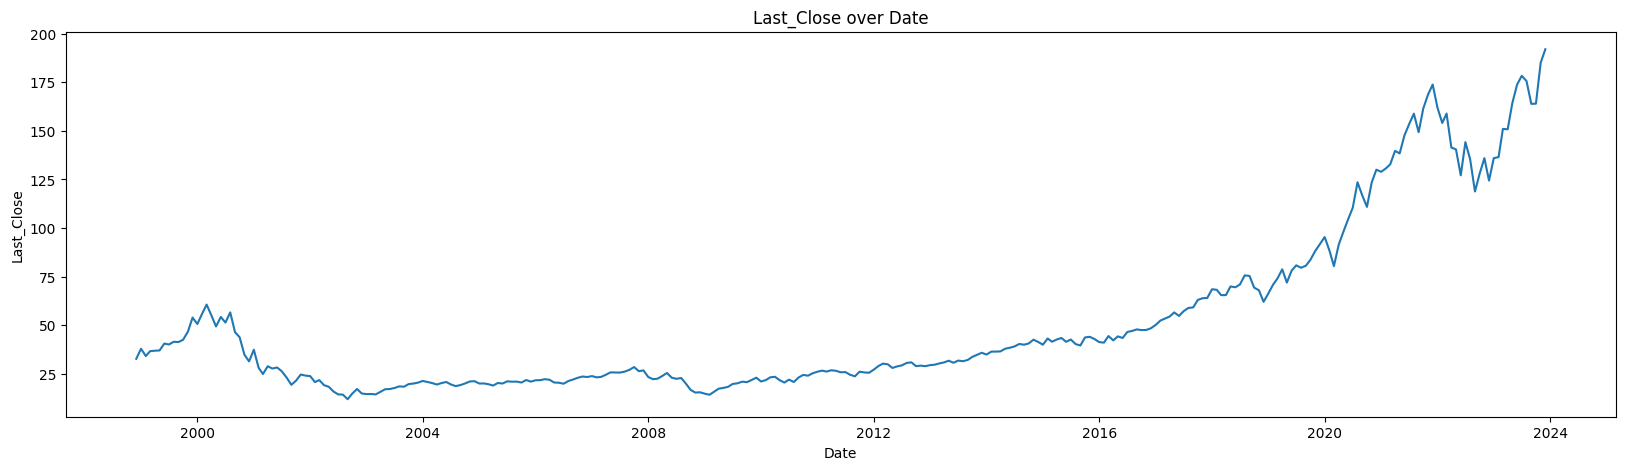

In [60]:
import matplotlib.pyplot as plt

def time_series_graph(df , x, y, figsize=(20,5)):

    plt.figure(figsize=figsize)
    plt.plot(df[x], df[y])
    plt.xlabel(x.title())
    plt.ylabel(y.title())
    plt.title(y.title() + " over " + x.title())
    plt.show()

time_series_graph(econ_df, "date", "Job Openings: Information (Monthly)")
time_series_graph(stocks_df, "date", "last_close")

In [8]:
df = fred_api.full_dataframe(list_variables)